In [2]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you


from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

In [3]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets

"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("MUTAG", verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data   # NB : this is a list of graphs, represented by dictionaries : first entry is an adjacency matrix, second are the node labels
y = dataset.target


dataset_MUT = fetch_dataset("MUTAG", verbose=False)
G_MUT = dataset_MUT.data
y_MUT = dataset_MUT.target

dataset_ENZ = fetch_dataset("ENZYMES", verbose=False)
G_ENZ = dataset_ENZ.data
y_ENZ = dataset_ENZ.target

dataset_NCI = fetch_dataset("NCI1", verbose=False)
G_NCI = dataset_NCI.data
y_NCI = dataset_NCI.target

In [4]:
# Computing the pairwise kernels between all graphs in the dataset, for each of the 3 datasets
gk = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram)   # n_iter=10 (parameter H) chosen arbitrarily, to coincide with question 4.1.4
K_MUT = gk.fit_transform(G_MUT)
K_ENZ = gk.fit_transform(G_ENZ)
K_NCI = gk.fit_transform(G_NCI)

print(K_NCI)

[[ 467  267  333 ...  455  397  424]
 [ 267  718  288 ...  755  671  652]
 [ 333  288  935 ...  482  429  446]
 ...
 [ 455  755  482 ... 1929 1231 1216]
 [ 397  671  429 ... 1231 1402 1020]
 [ 424  652  446 ... 1216 1020 1673]]


In [11]:
# Computing the rank of the WL subtree kernel matrix for all three datasets, and H=10 iterations
from numpy.linalg import matrix_rank
# NB : if n_iter has been changed from 10 in the previous cell, the kernel matrices need to be recomputed with n_iter=10 here !
print("MUTAG : kernel matrix rank : " + str(matrix_rank(K_MUT)) + ", number of samples : " + str(len(G_MUT)))
print("ENZYMES : kernel matrix rank : " + str(matrix_rank(K_ENZ)) + ", number of samples : " + str(len(G_ENZ)))
print("NCI1 : kernel matrix rank : " + str(matrix_rank(K_NCI)) + ", number of samples : " + str(len(G_NCI)))

MUTAG : kernel matrix rank : 175, number of samples : 188
ENZYMES : kernel matrix rank : 595, number of samples : 600
NCI1 : kernel matrix rank : 4002, number of samples : 4110


In [12]:
ONE = np.ones((len(K_MUT),len(K_MUT)))/len(K_MUT)
K_MUT_C = K_MUT - ONE@K_MUT - K_MUT@ONE + ONE@K_MUT@ONE

ONE = np.ones((len(K_ENZ),len(K_ENZ)))/len(K_ENZ)
K_ENZ_C = K_ENZ - ONE@K_ENZ - K_ENZ@ONE + ONE@K_ENZ@ONE

ONE = np.ones((len(K_NCI),len(K_NCI)))/len(K_NCI)
K_NCI_C = K_NCI - ONE@K_NCI - K_NCI@ONE + ONE@K_NCI@ONE

In [13]:
def kpca(K,n_comp):
    lambdas,alpha = np.linalg.eig(K)
    alpha = alpha.T
    alpha = np.array([v/np.linalg.norm(v) for v in alpha])

    tab = lambdas > 1e-11
    new_alpha = []
    for i in range(len(alpha)):
        if tab[i] :
            new_alpha.append(alpha[i])

    alpha = np.array(new_alpha)

    lambdas = np.extract(lambdas > 1e-11, lambdas)

    dico = {}
    for i in range(len(lambdas)):
        dico[lambdas[i]] = alpha[i]

    new_dico = {}
    for k in sorted(dico.keys(),reverse=True):
        new_dico[k] = dico[k]


    K_TF = []
    for j in range(len(K)):
        new_coord = []
        for k in range(n_comp): 
            somme = 0
            for i in range(len(alpha[k])):
                somme += alpha[k][i].real*K[i][j]
            new_coord.append(somme)
        K_TF.append(np.array(new_coord))

    K_TF = np.array(K_TF)

    return K_TF




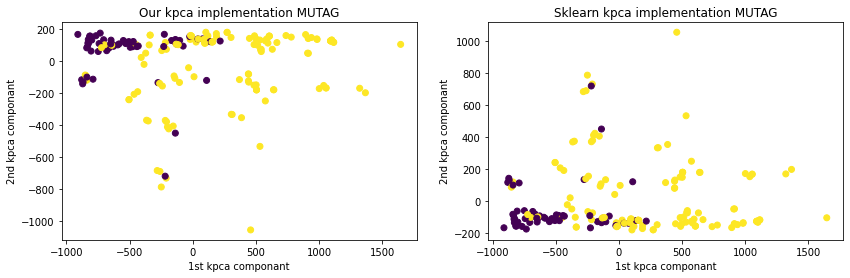

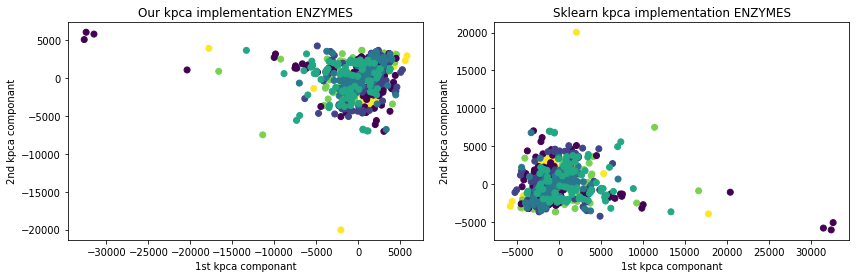

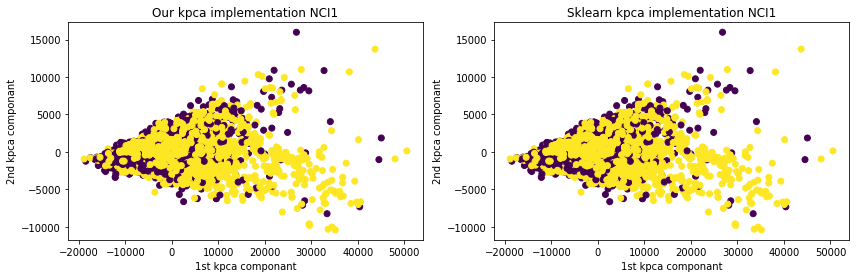

In [19]:
# this cell needs neerly 2 minutes to be executed because NCI dataset is big

K_MUT_TF = kpca(K_MUT_C,2)
K_ENZ_TF = kpca(K_ENZ_C,2)
K_NCI_TF = kpca(K_NCI_C,2)


def visualize(K_C,K_TF,y,title):
    tf = KernelPCA(n_components=2,kernel='linear')
    X_tf = tf.fit_transform(K_C)
    fig, (my_kpca_ax, kpca_ax) = plt.subplots(
        ncols=2, figsize=(14, 4)
    )
    my_kpca_ax.scatter(K_TF[:,0],K_TF[:,1],c=y)
    my_kpca_ax.set_xlabel("1st kpca componant")
    my_kpca_ax.set_ylabel("2nd kpca componant")
    my_kpca_ax.set_title("Our kpca implementation " + title)
    

    kpca_ax.scatter(X_tf[:,0],X_tf[:,1],c=y)
    kpca_ax.set_xlabel("1st kpca componant")
    kpca_ax.set_ylabel("2nd kpca componant")
    kpca_ax.set_title("Sklearn kpca implementation " + title)

visualize(K_MUT_C,K_MUT_TF,y_MUT,"MUTAG")
visualize(K_ENZ_C,K_ENZ_TF,y_ENZ,"ENZYMES")
visualize(K_NCI_C,K_NCI_TF,y_NCI,"NCI1")



In [18]:
def compute_dist(K):
    dist = []
    for i in range(len(K)):
        for j in range(i+1,len(K)):
            dist.append(K[i][i] + K[j][j] - 2*K[i][j])
    return dist

dist_MUT = compute_dist(K_MUT)
dist_ENZ = compute_dist(K_ENZ)
dist_NCI = compute_dist(K_NCI)


/home/anthony/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anthony/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/anthony/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anthony/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/anthony/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anthony/.local/lib/python3.8/site-packages/sk

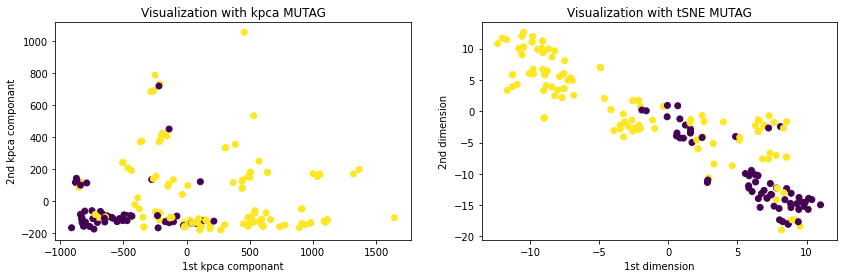

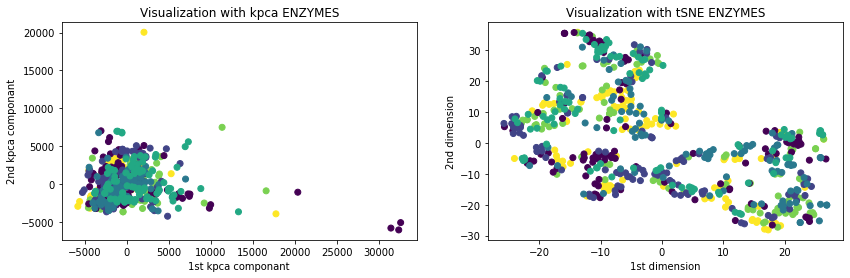

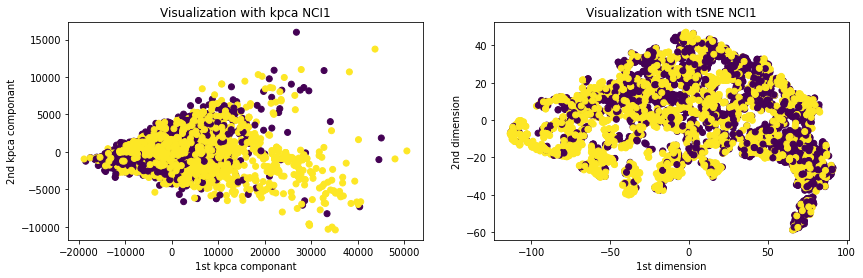

In [20]:
def compare_kpca_tsne(K_C,y,title):
    tf1 = KernelPCA(n_components=2,kernel='linear')
    tf2 = TSNE()
    X_tf_kpca = tf1.fit_transform(K_C)
    X_tf_tsne = tf2.fit_transform(K_C)
    fig, (kpca_ax, tsne_ax) = plt.subplots(
        ncols=2, figsize=(14, 4)
    )
    kpca_ax.scatter(X_tf_kpca[:,0],X_tf_kpca[:,1],c=y)
    kpca_ax.set_xlabel("1st kpca componant")
    kpca_ax.set_ylabel("2nd kpca componant")
    kpca_ax.set_title("Visualization with kpca " + title)

    tsne_ax.scatter(X_tf_tsne[:,0],X_tf_tsne[:,1],c=y)
    tsne_ax.set_xlabel("1st dimension")
    tsne_ax.set_ylabel("2nd dimension")
    tsne_ax.set_title("Visualization with tSNE " + title)

compare_kpca_tsne(K_MUT_C,y_MUT,"MUTAG")
compare_kpca_tsne(K_ENZ_C,y_ENZ,"ENZYMES")
compare_kpca_tsne(K_NCI_C,y_NCI,"NCI1")

In [5]:
def model_SVC(dataset,y,title,c,h):
    WL = WeisfeilerLehman(n_iter=h, base_graph_kernel=VertexHistogram) 
    X = WL.fit_transform(dataset)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SVC(C=c)
    model.fit(X_train,y_train)

    accuracy = model.score(X_test,y_test)
    print(str(accuracy) + " of accuracy for " + title)

model_SVC(G_MUT,y_MUT,"MUTAG",1e2,3)
model_SVC(G_ENZ,y_ENZ,"ENZYMES",1e2,3)
model_SVC(G_NCI,y_NCI,"NCI1",1e2,3)

0.868421052631579 of accuracy for MUTAG
0.43333333333333335 of accuracy for ENZYMES
0.7384428223844283 of accuracy for NCI1


In [10]:
# 2min30 to be executed
C = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4]
H = [1,2,3,4,5,6,7,8,9,10]
def find_best_params(data,y):
    cv_scores = []
    for c in C:
        for h in H:
            WL = WeisfeilerLehman(n_iter=h, base_graph_kernel=VertexHistogram) 
            X = WL.fit_transform(data)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = SVC(C=c)

            scores = cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')
            cv_scores.append((np.mean(scores),(c,h)))
    return sorted(cv_scores, key=lambda x: x[0],reverse=True)

scores_MUT = find_best_params(G_MUT,y_MUT)
scores_ENZ = find_best_params(G_ENZ,y_ENZ)
print("Best params for MUTAG is H = " + str(scores_MUT[0][1][1]) + " and C = " + str(scores_MUT[0][1][0]))
print("Best params for ENZYMES is H = " + str(scores_ENZ[0][1][1]) + " and C = " + str(scores_ENZ[0][1][0]))
        
    

Best params for MUTAG is H = 1 and C = 10.0
Best params for ENZYMES is H = 10 and C = 1000.0


In [11]:
# Cant't execute this cell
scores_NCI = find_best_params(G_NCI,y_NCI)
print("Best params for NCI1 is H = " + str(scores_NCI[0][1][1]) + " and C = " + str(scores_NCI[0][1][0]))


: 

: 